In [1]:
# Load modules

import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import zarr
import gcsfs

# Load data

In [5]:
vert_ds = xr.open_dataarray('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/vert_ds.nc')

dataarray_SST_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_sst_piControl_interp_2x2_15memens_2.nc')
dataarray_SST_cont.load()

dataarray_TOA_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_toa_piControl_2x2_15memens.nc')
dataarray_TOA_cont.load()

dataarray_SST_hist = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_sst_historical_interp_2x2_15memens_2.nc')
dataarray_SST_hist.load()

dataarray_TOA_hist = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_toa_historical_2x2_15memens_2.nc')
dataarray_TOA_hist.load()

dataarray_Qs_hist = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_surface_hist_interp_15memens_2.nc')
dataarray_Qs_hist.load()

dataarray_Qa_hist = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_horiz_hist_2x2_15memens_2.nc')
dataarray_Qa_hist.load()

ocean_hist = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_ocean_hist_2x2_15memens.nc')
ocean_hist.load()

<xarray.DataArray (time: 1500, name: 15, lat: 88, lon: 179)>
array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
...
         [-2.00913279e+02, -2.06987688e+02, -2.11773237e+02, ...,
          -1.86808497e+02, -1.91565994e+02, -1.93877993e+02],
         [-1.86243472e+02, -1.59101203e+02, -1.34016263e+02, ...,
          -2.01979945e+02, -1.89616358e+02, -1.86784718e+02],
         [-2.78120102e+02, -2.79788083e+02, -2.83608347e+02, ...,
          -2.91542084e+02, -2.80639760e+02, -2.74256728e+02]],

        [[-7.15127588e+00, -7.17544508e+00, -7.19953938e+00, ...,
          -7.01900230e+00, -7.05338505e+00, -7.08768180e+00],
         [-7.09303928e+00, -7.18291887e+00, -7.27283770e+00, ...,
          -6.71072006e+00, -6.79742267e+00, -6.89763858e+00],
         [-7.05300527e+00, -7.17045711e+00, -7.28742816e+00, ...,
          -6.54804259e+00, -6.66815613e+00, -6.79860768e+00],
         ...,
         [-1.61308705e+02, -1.44592885e+02, -1.34413314e+02, ...,
          -1.94769770e+02, -1.96659352e+02, -1.88590153e+02],
         [-1.06022143e+02, -9.88412029e+01, -9.27617527e+01, ...,
          -1.39612776e+02, -1.31027969e+02, -1.22683649e+02],
         [-3.96241346e+01, -3.84842441e+01, -3.72494463e+01, ...,
          -4.81284316e+01, -4.57977274e+01, -4.35754286e+01]]]])
Coordinates:
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * name     (name) object 'GFDL-ESM4' 'IPSL-CM6A-LR' ... 'NESM3' 'EC-Earth3'

In [6]:
def yearlylag_fit(sst_dataset, rad_dataset):
    """
    Yearly lagged regression
    
    """

    rad_dataset_yearly = rad_dataset.shift(time=-12).isel(time=slice(0,1488)) # Lagged by a year
    rad_dataset_yearly = rad_dataset_yearly.rolling(time=12, center=True).mean('time') # Mean over the year
    rad_dataset_yearly = rad_dataset_yearly.isel(time=slice(12,1476))
    sst_dataset_yearly = sst_dataset.rolling(time=12, center=True).mean('time') # Mean over the year
    sst_dataset_yearly = sst_dataset_yearly.isel(time=slice(12,1476))
    
    SST_radfit = xr.DataArray(np.zeros((15,88,179)), dims=['name','lat','lon'])
    model_index = 0
    for model in rad_dataset_yearly.coords['name'].values:
        lat_index = 0
        for lat in rad_dataset_yearly.coords['lat'].values:
            lon_index = 0
            for lon in rad_dataset_yearly.coords['lon'].values:
                SST_slice = sst_dataset_yearly.sel(lat=lat).sel(lon=lon).sel(name=model)
                rad_slice = rad_dataset_yearly.sel(lat=lat).sel(lon=lon).sel(name=model)
                idx = np.isfinite(SST_slice) & np.isfinite(rad_slice)
                if not SST_slice[idx].size or not rad_slice[idx].size:
                    break
                SST_radfit[model_index, lat_index, lon_index] = np.polyfit(SST_slice[idx], rad_slice[idx], deg=1)[0]     
                lon_index += 1
            lat_index += 1
        model_index += 1
        print(model)

    SST_radfit.coords['lon'] = rad_dataset_yearly['lon'].values
    SST_radfit.coords['lat'] = rad_dataset_yearly['lat'].values
    SST_radfit.coords['name'] = rad_dataset_yearly['name'].values
    SST_radfit
    return SST_radfit

# piControl TOA + SST

In [4]:
sst_toa_cont_fit = yearlylag_fit(dataarray_SST_cont, dataarray_TOA_cont)

BCC-CSM2-MR
BCC-ESM1
CNRM-CM6-1
CNRM-ESM2-1
CanESM5-CanOE
CanESM5
GISS-E2-1-G
HadGEM3-GC31-LL
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
MPI-ESM-1-2-HAM
GFDL-CM4
GFDL-ESM4
GISS-E2-1-H


In [8]:
sst_toa_cont_fit_mean = sst_toa_cont_fit.mean('name')

Text(0.5, 1.0, 'Yearly Lagged Regression of piControl SST and TOA Radiation (N=15)')

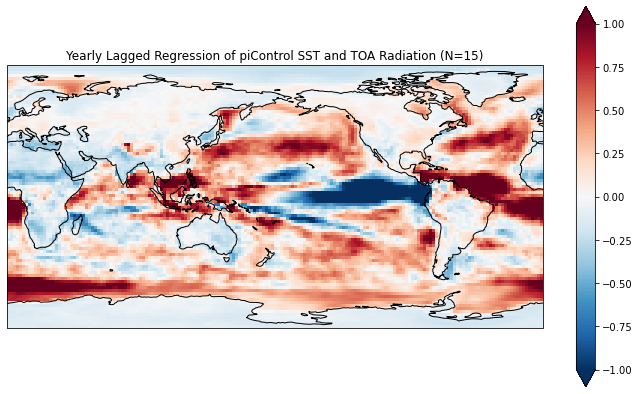

In [12]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_toa_cont_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-1, vmax=1, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
plt.title('Yearly Lagged Regression of piControl SST and TOA Radiation (N=15)')

Text(0.5, 1.0, 'Yearly Lagged Regression of piControl SST and TOA Radiation (N=15)')

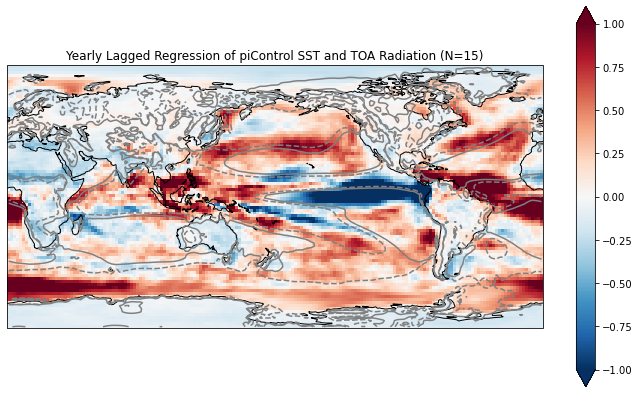

In [13]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_toa_cont_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-1, vmax=1, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Yearly Lagged Regression of piControl SST and TOA Radiation (N=15)')

# Historical TOA + SST

In [14]:
sst_toa_hist_fit = yearlylag_fit(dataarray_SST_hist, dataarray_TOA_hist)

BCC-CSM2-MR
BCC-ESM1
CESM2
CNRM-CM6-1
CNRM-ESM2-1
CanESM5-CanOE
CanESM5
EC-Earth3
GFDL-ESM4
GISS-E2-1-G
HadGEM3-GC31-LL
IPSL-CM6A-LR
MPI-ESM-1-2-HAM
NESM3
UKESM1-0-LL


In [15]:
sst_toa_hist_fit

<xarray.DataArray (name: 15, lat: 88, lon: 179)>
array([[[-0.13006986, -0.135304  , -0.14617679, ..., -0.10554253,
         -0.1143563 , -0.11948628],
        [-0.1029932 , -0.1120975 , -0.12130792, ..., -0.07513302,
         -0.0824246 , -0.08697517],
        [-0.03724151, -0.04088748, -0.05066952, ..., -0.00832729,
         -0.01641364, -0.02433129],
        ...,
        [ 0.10747661,  0.09721057,  0.09404452, ...,  0.15715298,
          0.1410851 ,  0.1375736 ],
        [ 0.2918159 ,  0.28344559,  0.26882556, ...,  0.29888562,
          0.29575782,  0.29624856],
        [ 0.20946454,  0.20452866,  0.201342  , ...,  0.23376468,
          0.23114367,  0.22592115]],

       [[-0.20356731, -0.20548186, -0.20467538, ..., -0.20282764,
         -0.20151244, -0.20115897],
        [-0.13485761, -0.13877608, -0.14282843, ..., -0.12223613,
         -0.12497158, -0.12700454],
        [-0.10954905, -0.11237295, -0.11327768, ..., -0.0882683 ,
         -0.09537688, -0.10254533],
...
        [-0.0358962 , -0.02314578, -0.00314723, ..., -0.10157232,
         -0.09068859, -0.07296063],
        [-0.10941781, -0.10665673, -0.09195174, ..., -0.1536809 ,
         -0.13415541, -0.12539497],
        [-0.16704248, -0.15527552, -0.1547888 , ..., -0.18955409,
         -0.17843647, -0.17370995]],

       [[-0.2047352 , -0.20369908, -0.19738604, ..., -0.21521721,
         -0.21197736, -0.21080022],
        [-0.2126322 , -0.20012005, -0.18989811, ..., -0.24999537,
         -0.23920122, -0.22992688],
        [-0.22902722, -0.2175393 , -0.20509376, ..., -0.26213584,
         -0.25545322, -0.24760445],
        ...,
        [ 0.07608095,  0.06688936,  0.06322317, ...,  0.09976427,
          0.08822099,  0.08350817],
        [ 0.10471018,  0.08954595,  0.08674452, ...,  0.12657067,
          0.11979247,  0.12111679],
        [ 0.00180277, -0.00271863,  0.00362783, ...,  0.0068366 ,
         -0.00166318,  0.0017954 ]]])
Coordinates:
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * name     (name) object 'BCC-CSM2-MR' 'BCC-ESM1' ... 'NESM3' 'UKESM1-0-LL'

In [16]:
sst_toa_hist_fit_mean = sst_toa_hist_fit.mean('name')

## Old dataset

Text(0.5, 1.0, 'Yearly Lagged Regression of Historical SST and TOA Radiation (N=15)')

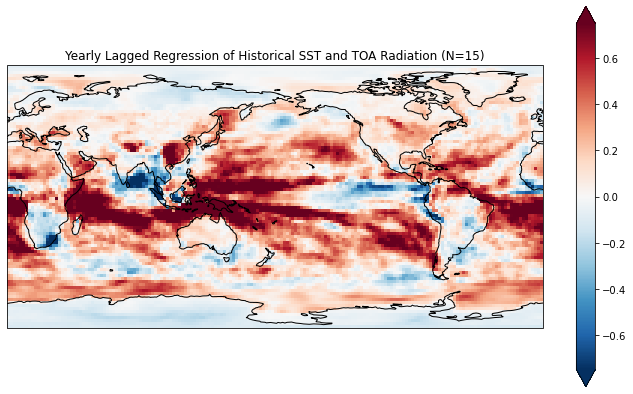

In [14]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_toa_hist_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-0.75, vmax=0.75, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
plt.title('Yearly Lagged Regression of Historical SST and TOA Radiation (N=15)')

Text(0.5, 1.0, 'Yearly Lagged Regression of Historical SST and TOA Radiation (N=15)')

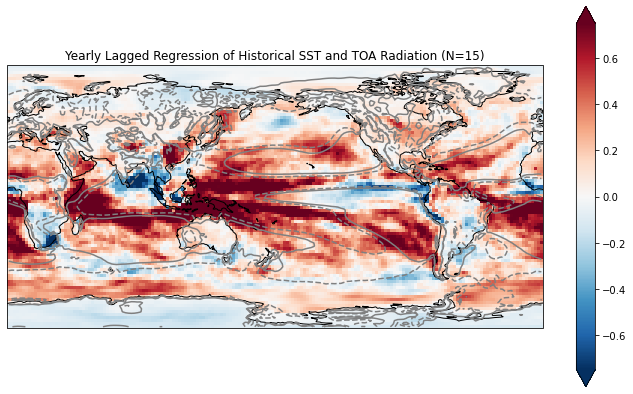

In [15]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_toa_hist_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-0.75, vmax=0.75, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Yearly Lagged Regression of Historical SST and TOA Radiation (N=15)')

## New dataset

Text(0.5, 1.0, 'Yearly Lagged Regression of Historical SST and TOA Radiation (N=15)')

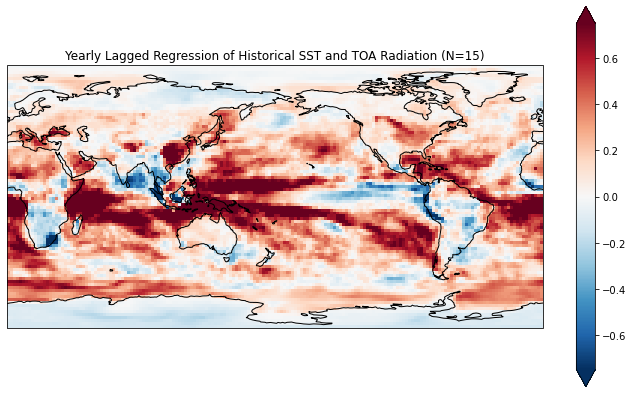

In [18]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_toa_hist_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-0.75, vmax=0.75, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
plt.title('Yearly Lagged Regression of Historical SST and TOA Radiation (N=15)')

Text(0.5, 1.0, 'Yearly Lagged Regression of Historical SST and TOA Radiation (N=15)')

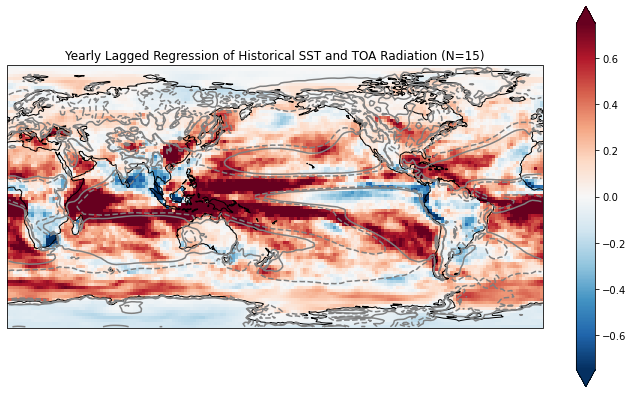

In [17]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_toa_hist_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-0.75, vmax=0.75, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Yearly Lagged Regression of Historical SST and TOA Radiation (N=15)')

# Historical SST + Qs Radiation

In [4]:
sst_surf_fit = yearlylag_fit(dataarray_SST_hist, dataarray_Qs_hist)

BCC-CSM2-MR
BCC-ESM1
CESM2
CNRM-CM6-1
CNRM-ESM2-1
CanESM5-CanOE
CanESM5
EC-Earth3
GISS-E2-1-G
HadGEM3-GC31-LL
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
MPI-ESM-1-2-HAM
NESM3


In [5]:
sst_surf_fit

<xarray.DataArray (name: 15, lat: 88, lon: 179)>
array([[[ 4.61612244e-02,  4.63707719e-02,  4.68118838e-02, ...,
          4.52765355e-02,  4.55024673e-02,  4.52427405e-02],
        [ 4.09121093e-02,  3.99689267e-02,  3.89579372e-02, ...,
          4.03287187e-02,  3.97838782e-02,  4.05740122e-02],
        [ 2.77154597e-02,  2.63895071e-02,  2.45742025e-02, ...,
          3.26942986e-02,  3.14080735e-02,  3.05141268e-02],
        ...,
        [-1.05762760e-01, -1.01185177e-01, -9.65287761e-02, ...,
         -1.42288489e-01, -1.29914886e-01, -8.85289008e-02],
        [ 1.55161773e-01,  1.62850629e-01,  1.75588399e-01, ...,
          7.32092693e-02,  9.33073933e-02,  1.18995617e-01],
        [ 1.85412694e-01,  1.85359083e-01,  2.06917449e-01, ...,
          1.06753178e-01,  1.57482017e-01,  1.69479865e-01]],

       [[ 7.37311531e-03,  6.82327745e-03,  7.35474281e-03, ...,
          8.72487499e-03,  8.39469027e-03,  7.73220174e-03],
        [ 1.76799232e-03,  1.39603529e-03,  2.41907640e-03, ...,
          2.42447087e-03,  2.26503225e-03,  2.28349280e-03],
        [-2.19173859e-03, -2.11850916e-03, -1.10334133e-03, ...,
         -1.02984329e-03, -1.45024125e-03, -1.11048087e-03],
...
        [ 2.69619988e-01,  2.30069616e-01,  1.83384437e-01, ...,
          3.68036118e-01,  3.48303805e-01,  3.29373684e-01],
        [ 2.55497850e-01,  2.54543212e-01,  2.53326937e-01, ...,
          2.85354043e-01,  2.77634719e-01,  2.68592738e-01],
        [ 1.49380270e-01,  1.51474257e-01,  1.50698898e-01, ...,
          1.54003434e-01,  1.52507220e-01,  1.49977507e-01]],

       [[-3.49013635e-02, -3.43270159e-02, -3.19771134e-02, ...,
         -3.93355508e-02, -3.82002415e-02, -3.55123054e-02],
        [-3.08888956e-02, -2.95830185e-02, -2.54205773e-02, ...,
         -3.76784565e-02, -3.62459041e-02, -3.36101530e-02],
        [-2.13715072e-02, -2.25682585e-02, -2.23253246e-02, ...,
         -2.20595869e-02, -2.02415636e-02, -1.88294727e-02],
        ...,
        [ 1.79864628e-01,  1.77777461e-01,  1.80408799e-01, ...,
          2.39927541e-01,  1.90957283e-01,  1.73423630e-01],
        [ 3.56142923e-01,  3.34418535e-01,  3.05498310e-01, ...,
          3.59172504e-01,  3.68907404e-01,  3.63759823e-01],
        [ 1.73194801e-01,  1.96344860e-01,  1.84144565e-01, ...,
          2.14352353e-01,  2.28515144e-01,  2.16868999e-01]]])
Coordinates:
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * name     (name) object 'BCC-CSM2-MR' 'BCC-ESM1' ... 'NESM3'

In [6]:
sst_surf_fit_mean = sst_surf_fit.mean('name')

Text(0.5, 1.0, 'Yearly Lagged Regression of Historical SST and Qs Radiation (N=15)')

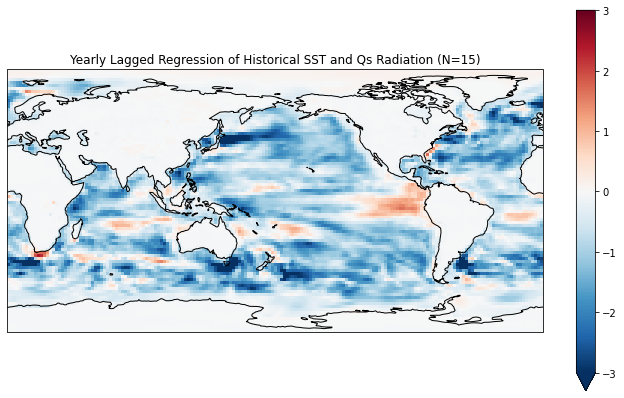

In [9]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_surf_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-3, vmax=3, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
plt.title('Yearly Lagged Regression of Historical SST and Qs Radiation (N=15)')

Text(0.5, 1.0, 'Yearly Lagged Regression of Historical SST and Qs Radiation (N=15)')

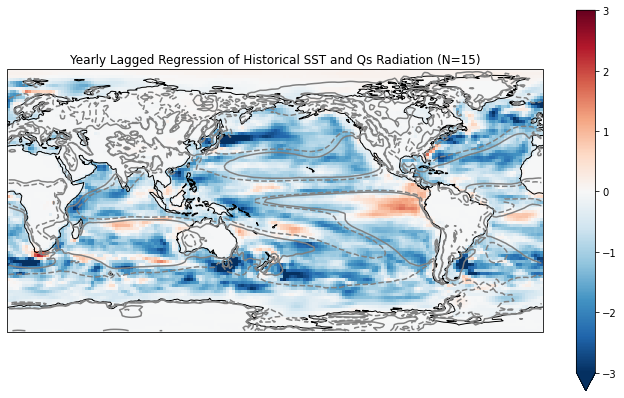

In [10]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_surf_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-3, vmax=3, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Yearly Lagged Regression of Historical SST and Qs Radiation (N=15)')